In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import numpy as np

# Tiền xử lí dữ liệu
- Loại dữ liệu từ csv
- is null
- duplicate
- outlier

In [40]:
estate_data = pd.read_csv('data/vietnam_housing_dataset.csv')

In [41]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30229 entries, 0 to 30228
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            30229 non-null  object 
 1   Area               30229 non-null  float64
 2   Frontage           18665 non-null  float64
 3   Access Road        16932 non-null  float64
 4   House direction    8990 non-null   object 
 5   Balcony direction  5246 non-null   object 
 6   Floors             26626 non-null  float64
 7   Bedrooms           25067 non-null  float64
 8   Bathrooms          23155 non-null  float64
 9   Legal status       25723 non-null  object 
 10  Furniture state    16110 non-null  object 
 11  Price              30229 non-null  float64
dtypes: float64(7), object(5)
memory usage: 2.8+ MB


In [42]:
def extract_xa(address):
    if pd.isna(address):
        return None
    
    # Find part that contains Xã / Phường / Thị trấn
    match = re.search(r"(Xã|Phường|Thị trấn)\s+[^,]+", address, re.IGNORECASE)
    if match:
        return match.group(0).strip()
    return None


def extract_tinh(address):
    if pd.isna(address):
        return None
    
    # Always take the LAST comma-separated part
    parts = [p.strip() for p in address.split(",")]
    return parts[-1] if len(parts) > 0 else None


# Apply extraction
estate_data["xa_phuong"] = estate_data["Address"].apply(extract_xa)
estate_data["tinh_thanhpho"] = estate_data["Address"].apply(extract_tinh)

In [43]:
estate_data = estate_data.drop(['Balcony direction', 'House direction', 'Furniture state', 'Access Road', 'Address'], axis=1)

In [44]:
estate_data = estate_data.dropna()

In [45]:
estate_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,13604.0,67.282032,44.550934,3.1,40.0,56.7,80.0,585.0
Frontage,13604.0,5.326507,4.569687,1.0,4.0,4.4,5.0,75.0
Floors,13604.0,3.309321,1.345115,1.0,2.0,3.0,4.0,9.0
Bedrooms,13604.0,3.530065,1.283887,1.0,3.0,3.0,4.0,9.0
Bathrooms,13604.0,3.400691,1.385987,1.0,2.0,3.0,4.0,9.0
Price,13604.0,5.843725,2.179763,1.0,4.2,5.8,7.5,11.5


In [46]:
estate_data.describe(exclude='number').T

,count,unique,top,freq
Legal status,13604,2,Have certificate,13165
xa_phuong,13604,950,Phường 12,203
tinh_thanhpho,13604,78,Hồ Chí Minh,5264


In [47]:
area_index = estate_data[(estate_data['Area'] > 150)].index
estate_data = estate_data.drop(area_index, axis=0)

frontage_index = estate_data[(estate_data['Frontage'] > 13)].index
estate_data = estate_data.drop(frontage_index, axis=0)

estate_data.shape

(12885, 9)

In [48]:
estate_data.duplicated()

10       False
18       False
19       False
20       False
23       False
         ...  
30205    False
30210    False
30218    False
30220    False
30224    False
Length: 12885, dtype: bool

In [49]:
legal_stat_categories = estate_data['Legal status'].astype('category').cat.categories
estate_data['Legal status encoded'] = estate_data['Legal status'].astype('category').cat.codes

xa_categories = estate_data['xa_phuong'].astype('category').cat.categories
estate_data['xa_phuong encoded'] = estate_data['xa_phuong'].astype('category').cat.codes

tinh_categories = estate_data['tinh_thanhpho'].astype('category').cat.categories
estate_data['tinh_thanhpho encoded'] = estate_data['tinh_thanhpho'].astype('category').cat.codes

estate_data.head()

,Area,Frontage,Floors,Bedrooms,Bathrooms,Legal status,Price,xa_phuong,tinh_thanhpho,Legal status encoded,xa_phuong encoded,tinh_thanhpho encoded
10,80.0,5.0,5.0,6.0,6.0,Have certificate,10.00,Xã Nghĩa Trụ,Hưng Yên,0,707,22
18,65.0,5.0,5.0,5.0,4.0,Sale contract,7.80,Xã Long Hưng,Hưng Yên,1,686,22
19,46.0,4.6,4.0,4.0,5.0,Have certificate,7.99,Phường 12,Hồ Chí Minh,0,15,26
20,75.0,5.0,5.0,7.0,5.0,Sale contract,8.70,Xã Long Hưng,Hưng Yên,1,686,22
23,60.0,3.5,2.0,6.0,5.0,Have certificate,5.60,Phường 22,Hồ Chí Minh,0,25,26


# Phân tích mối quan hệ của các thuộc tính
- heatmap
- biểu đồ (cột/đường/top) -> sau mỗi biểu đồ cần 1 kết luận

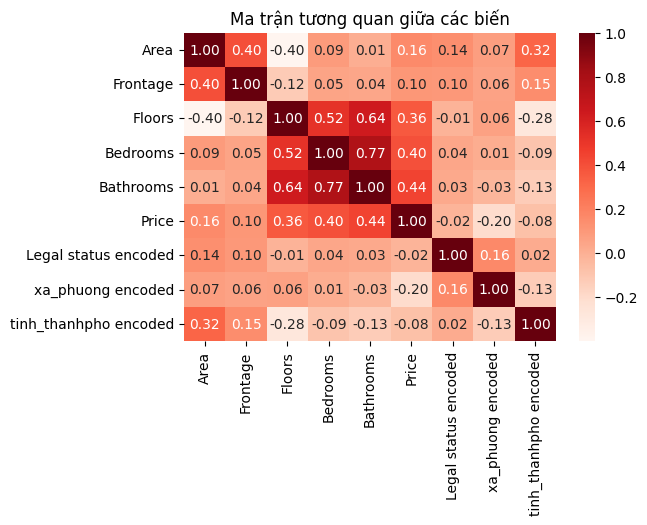

In [50]:
plt.figure(figsize=(6, 4))
sns.heatmap(estate_data.select_dtypes(include='number').corr(), annot=True, cmap=plt.cm.Reds, fmt=".2f")
plt.title("Ma trận tương quan giữa các biến")
plt.show()

Text(0.5, 1.0, 'Distribution of bathroom counts')

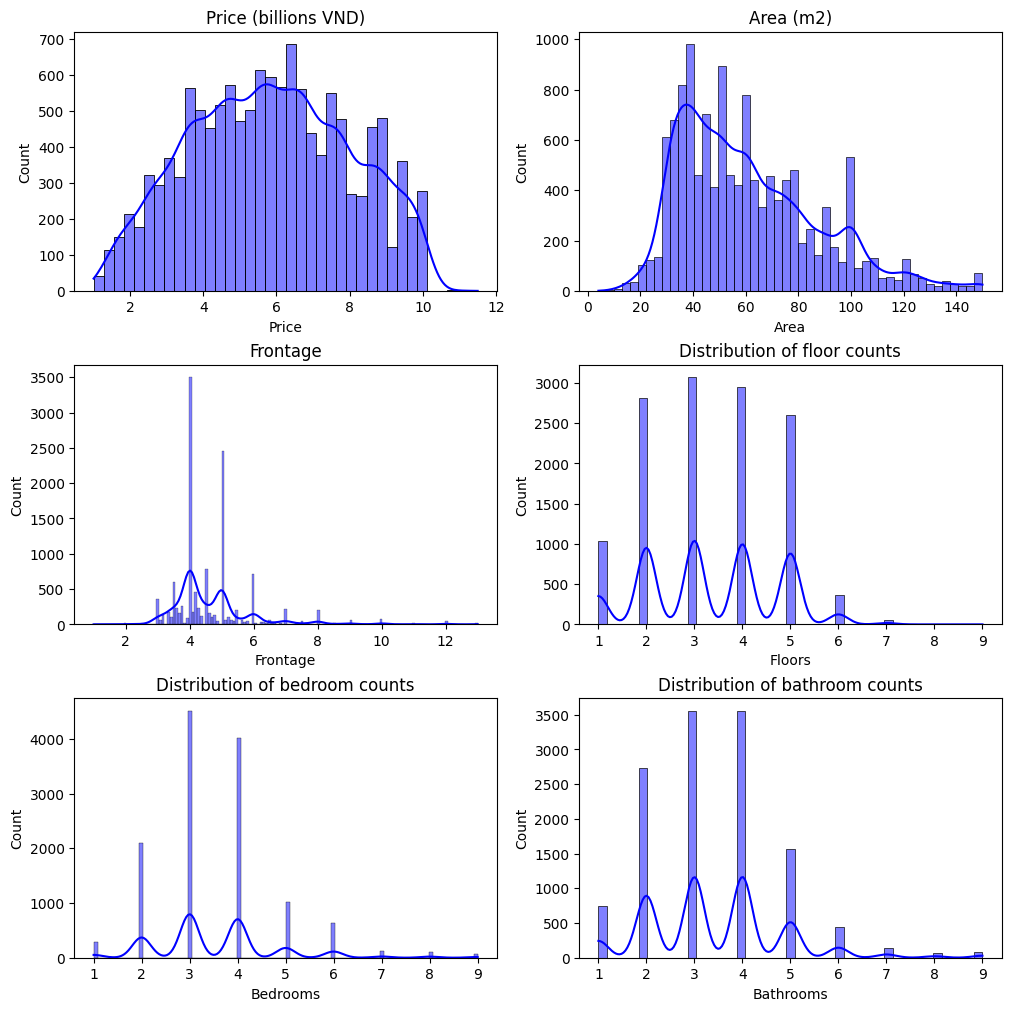

In [51]:
his_fig, his_axis = plt.subplots(3, 2, figsize=(10, 10), layout="constrained")
plt.title("Distribution") #histogram for numerical data

sns.histplot(data=estate_data, x=estate_data['Price'], kde=True, color='blue', ax=his_axis[0,0]).set_title("Price (billions VND)")
sns.histplot(data=estate_data, x=estate_data['Area'], kde=True, color='blue', ax=his_axis[0,1]).set_title("Area (m2)")
sns.histplot(data=estate_data, x=estate_data['Frontage'], kde=True, color='blue', ax=his_axis[1,0]).set_title("Frontage")
sns.histplot(data=estate_data, x=estate_data['Floors'], kde=True, color='blue', ax=his_axis[1,1]).set_title("Distribution of floor counts")
sns.histplot(data=estate_data, x=estate_data['Bedrooms'], kde=True, color='blue', ax=his_axis[2,0]).set_title("Distribution of bedroom counts")
sns.histplot(data=estate_data, x=estate_data['Bathrooms'], kde=True, color='blue', ax=his_axis[2,1]).set_title("Distribution of bathroom counts")


In [52]:
top5_province_index = estate_data["tinh_thanhpho"].value_counts().iloc[:5].index.to_list()
other_count = estate_data["tinh_thanhpho"].value_counts().iloc[5:].sum()
plot_category = top5_province_index+['Tỉnh_TP khác']

plot_df = pd.DataFrame({'Tỉnh_TP': plot_category, 'Count': estate_data["tinh_thanhpho"].value_counts().nlargest(5).tolist() + [other_count]})

Text(0.5, 1.0, 'Province')

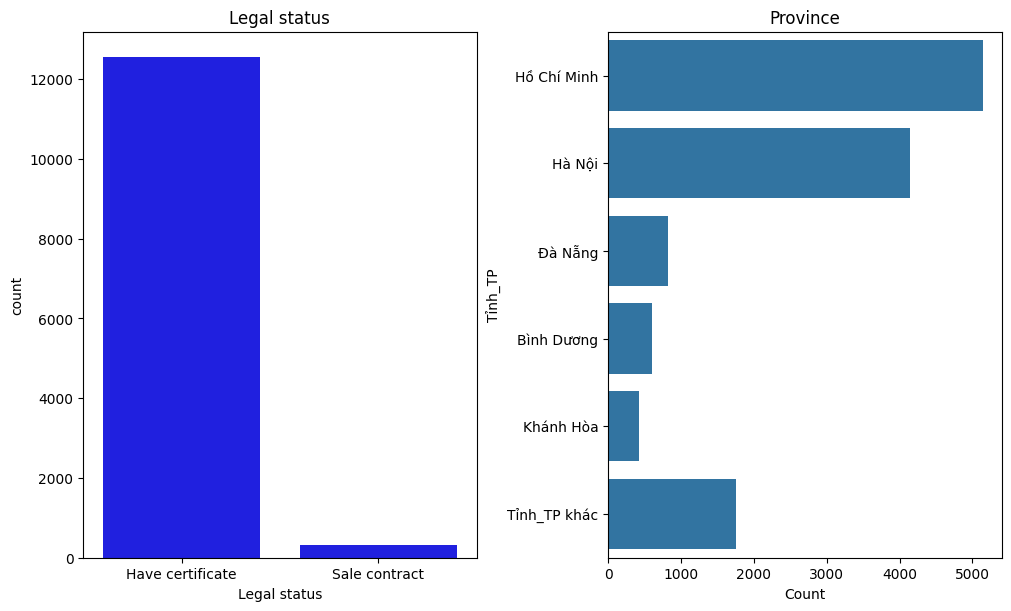

In [53]:
count_fig, count_axis = plt.subplots(1, 2, figsize=(10, 6), layout="constrained")
plt.title("Distribution")

sns.countplot(data=estate_data, x=estate_data['Legal status'], ax=count_axis[0], color='blue').set_title("Legal status")
sns.barplot(x='Count', y='Tỉnh_TP', data=plot_df, order=plot_category, ax=count_axis[1], legend=False).set_title("Province")

In [54]:
features = list(estate_data.select_dtypes(include='number').columns)

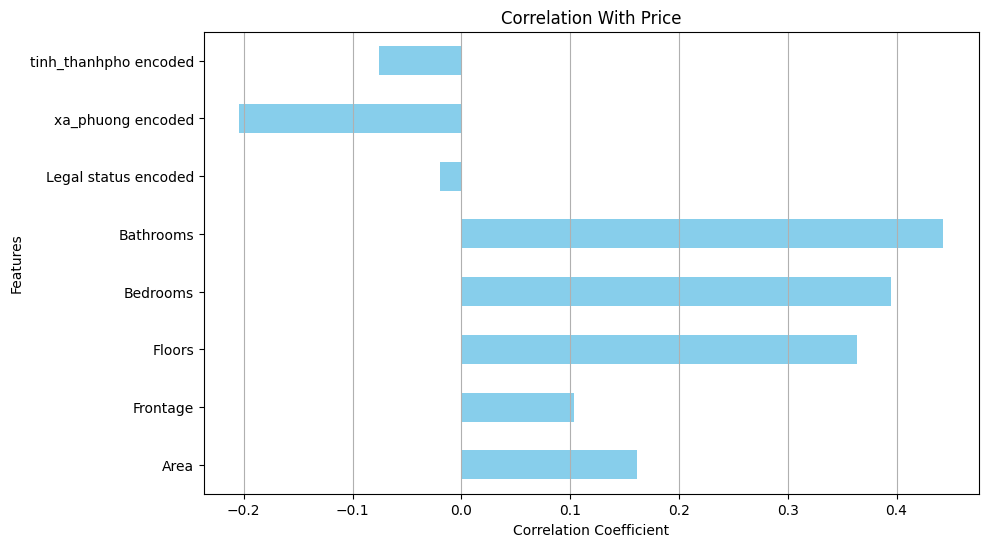

In [55]:
correlations = estate_data[features].corr()['Price'].drop(['Price'])

plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color='skyblue')
plt.title('Correlation With Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()

# Train - test - prediction
- Tạo mô hình
- Chia tập train - test
- Train (fit)
- Đánh giá mô hình với R^2 + MSE với tập test
- Dự đoán (có thể vẽ mô hình)

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X = estate_data.drop(columns=['tinh_thanhpho', 'xa_phuong', 'Legal status', 'Price'], axis=1)
y = estate_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize model
model = LinearRegression()


In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate model's performance
def evaluate_performance(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print('Mean Absolute Error: ', mae)
    print('Mean Squared Error: ', mse)
    print('Root Mean Squared Error: ', rmse)
    print('R2 Score: ', r2)

    
evaluate_performance(y_test, y_pred)

Mean Absolute Error:  1.4179497163874255
Mean Squared Error:  3.12856343204554
Root Mean Squared Error:  1.7687745565915234
R2 Score:  0.33261909952455215
